# Demo - Synthetic data generation

Synthetic data can be leverage for different purposes - from dataset augmentation to the simulation of unforeseen scenarios, synthetic data is a must-have in the data science toolkit. 
But, one of the main challenges around data sciene remains on the data access side while leveraging the right infrastructure to run ML workflows. Under this context, synthetic data can serve as a proxy for the development of ML models without the need to access the real data, while providing the information in it's most granular format. 

In this notebook we demo this capabilities while leveraging YData's proprietaty tools combined with the platforms ML tools for scalability and productiziation of the ML flows. 

## Accessing the data

In YData's platform we make available scalable connectors to a variety of different data storages. The connection to the data can be made either through the UI or also via Notebooks. Below we show how we can use in the Notebooks a connector previously created through the UI.

In [ ]:
## Let's first list the existing created datasources
from ydata.datasources import DataSources

datasources = DataSources.list()

print("\033[1m\nExisting datasoures\n\033[0m")
for datasource in datasources:
    print(datasource)

In [ ]:
#creating the datasource and reading the data
datasource = DataSources.get(datasources[1].uid)
data = datasource.read()

In [1]:
import os
from pathlib import Path

os.environ['DATASOURCE_API_URL']=""
os.environ['HOSTNAME']=""
os.environ['RUNNING_ENV']="LOCAL"

In [2]:
import json
from ydata.connectors import S3Connector
from ydata.connectors.filetype import FileType

def read_json(path: str):
    "Reads a JSON file."
    with open(path, 'r') as f:
        j = json.load(f)
    return j

token=read_json('secrets/s3_credentials.json')
connector = S3Connector(**token)
data = connector.read_file(path='s3://ydata-dev/regular/french_motor_claims/data.csv', file_type=FileType.CSV)

### The object dataset

Because data analysis and the process of data science do rely on scalability and the hability for systems to analyse and ingest high volumes of data, we've integrated a pythonic solution to distributed the data flows: **Dask**. 
In any case, **Pandas** and **Numpy** are still available if you are more familiar with it.

In [3]:
pd_data = data.to_pandas()
np_data = data.to_numpy()

In [4]:
#You can count the unique values existing in a column
print(data.value_counts('ClaimNb'))

#Or for example, you can also the total count of missing values in a Dataset
print(data.nmissings)

#You can also have a clear view on what columns have missing values and in what percentage
print(data.missings)

{'0': 643953, '1': 32178, '2': 1784, '3': 82, '4': 7, '11': 3, '5': 2, '16': 1, '6': 1, '8': 1, '9': 1}
0
{'IDpol': 0, 'ClaimNb': 0, 'Exposure': 0, 'Area': 0, 'VehPower': 0, 'VehAge': 0, 'DrivAge': 0, 'BonusMalus': 0, 'VehBrand': 0, 'VehGas': 0, 'Density': 0, 'Region': 0}


In [5]:
#If you prefer you can just explore the distributed benefits that Dask delivers to your day to day data science activities
import dask
dd_data = data.to_dask()

num_pol_id, num_claims_unique, num_veh_power = dask.compute(dd_data['IDpol'].nunique(),\
                                                            dd_data['ClaimNb'].nunique(),\
                                                            dd_data['VehPower'].nunique())
print("Unique content IDs: {}".format(num_pol_id))
print("Unique task container IDs: {}".format(num_claims_unique))
print("Number of content types: {}".format(num_veh_power))


Unique content IDs: 678013
Unique task container IDs: 11
Number of content types: 12


## Synthetic data generation

For the process of generating the needed synthetic data we are going to leverage YData's proprietary library. The process of generating synthetic data, similarly to the data sources can be done both through the UI but also through code.
In this demo we are portrayig how it can be done through code.

In [6]:
sample = data.sample(size=0.01)

In [7]:
schema = sample.infered_dtypes

print('Dataset infered schema: {}'.format(schema))
#Vou ter de ter de alterar a função infered_dtypes.
#Dataset maiores e leva demasiado tempo
#Alterar as cores dos gráficos e alterar a forma dos plots

Dataset infered schema: {'IDpol': 'int', 'ClaimNb': 'int', 'Exposure': 'float', 'Area': 'string', 'VehPower': 'int', 'VehAge': 'int', 'DrivAge': 'int', 'BonusMalus': 'int', 'VehBrand': 'string', 'VehGas': 'string', 'Density': 'int', 'Region': 'string'}


In [8]:
#Showing here the dataset schema example
schema

{'IDpol': 'int',
 'ClaimNb': 'int',
 'Exposure': 'float',
 'Area': 'string',
 'VehPower': 'int',
 'VehAge': 'int',
 'DrivAge': 'int',
 'BonusMalus': 'int',
 'VehBrand': 'string',
 'VehGas': 'string',
 'Density': 'int',
 'Region': 'string'}

In [56]:
from ydata.synthesizers.regular import RegularSynthesizer
from ipywidgets import interact
from ipywidgets import IntSlider

TRAIN = False

if TRAIN:
    # Previously we have trained a synthesizer with YData's package. So we are going to load the trained model definition
    #But the training process of the synthesizer can be as simple as using two lines of code
    claims_synth = RegularSynthesizer()
    claims_synth.fit(pd_data)
else:
    claims_synth = RegularSynthesizer.load('claims_synth.pkl')

#And generate new samples with de desired size
@interact(n_sample=IntSlider(value=0, min=1, max=len(pd_data), step=1))
def generate_sample(n_sample):
    return claims_synth.sample(n_sample)
    
synth_data = generate_sample(8000)

INFO: 2021-06-23 12:08:57,180 Start generating model samples.
INFO: 2021-06-23 12:08:57,181 Current batch_size is set as 1000


INFO: 2021-06-23 12:08:57,252 Start generating model samples.
INFO: 2021-06-23 12:08:57,253 Current batch_size is set as 1000


In [11]:
from sklearn.preprocessing import OrdinalEncoder
from numpy import concatenate
import pandas as pd

#pd_data=pd_data.drop('IDpol', axis=1)
synth_data = synth_data.to_pandas()
for col in pd_data.columns:
    pd_data[col]=pd_data[col].astype(synth_data.dtypes[col])

# Select columns
cat_cols= ['Area','VehBrand','VehGas','Region']
columns = ['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge',
           'BonusMalus', 'Density','Area','VehBrand','VehGas','Region' ]

# Encode categorical 
encoder = OrdinalEncoder()
cat_original = encoder.fit_transform(pd_data[cat_cols])
cat_synth = encoder.fit_transform(synth_data[cat_cols])

# Concatenate the results
pd_data_processed = pd.DataFrame(concatenate([pd_data.drop(cat_cols,axis=1),cat_original],axis=1),columns=columns)
synth_data_processed = pd.DataFrame(concatenate([synth_data.drop(cat_cols,axis=1),cat_synth],axis=1),columns=columns)

### Evaluating the quality of the generated data

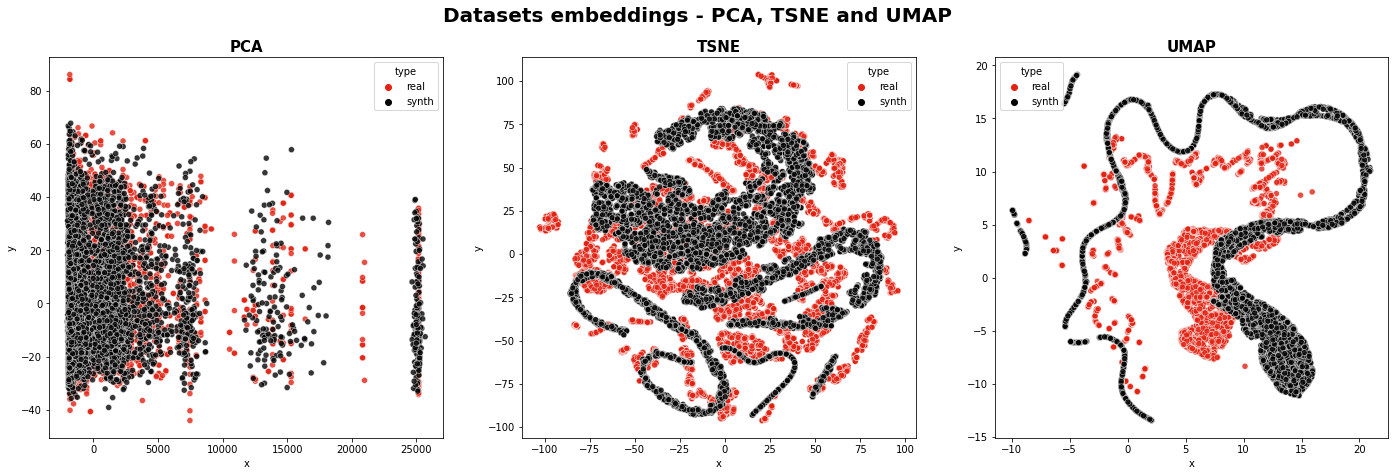

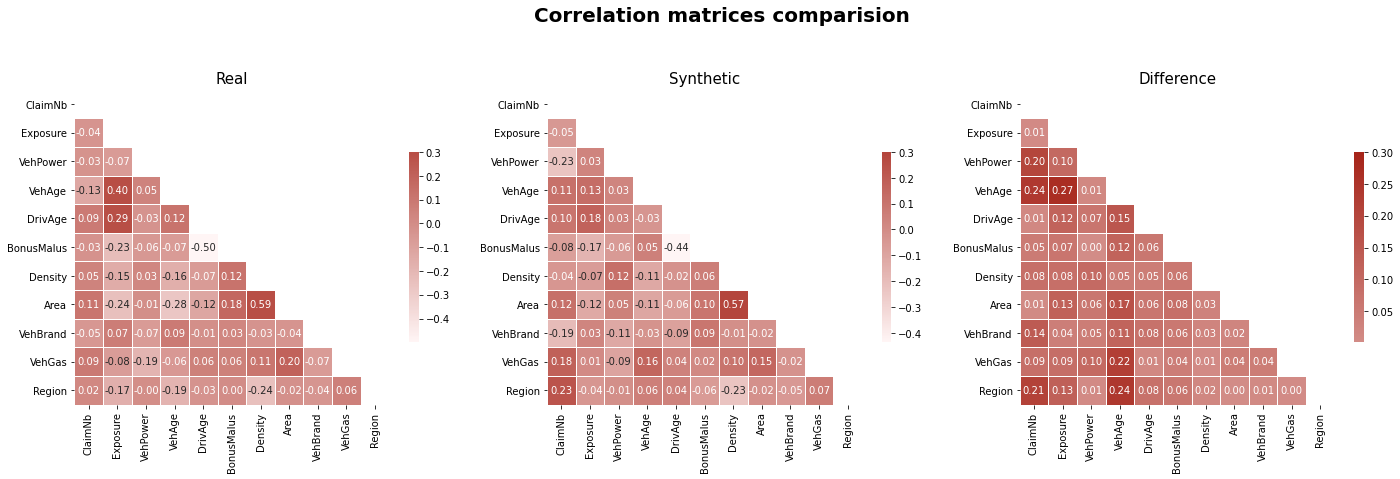

# Original Events: 10K
# New Events Generated: 10K
# Missing Values Detected: 0
Utility Score: 0.81
Privacy Score: 2.3%
Fidelity Score: 1.09


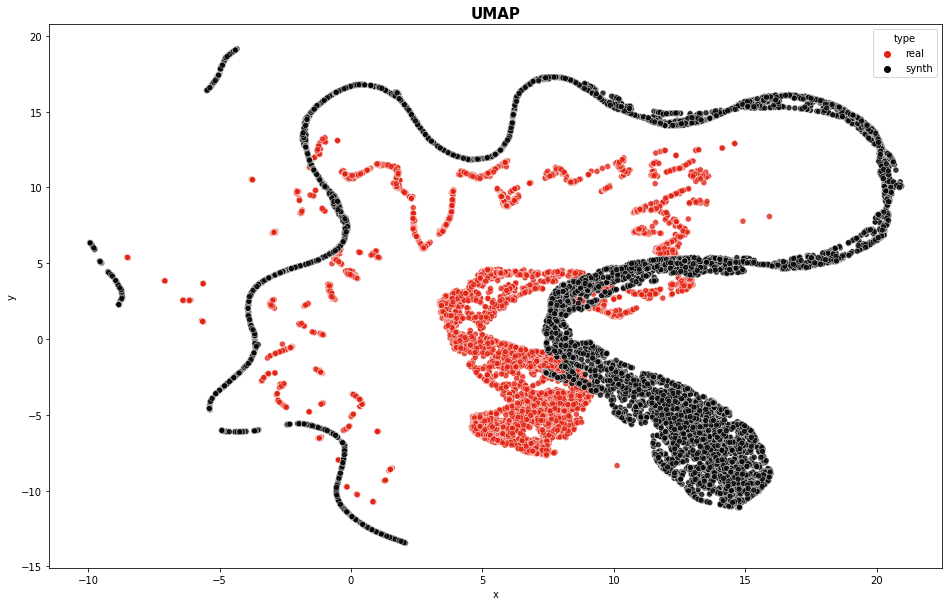

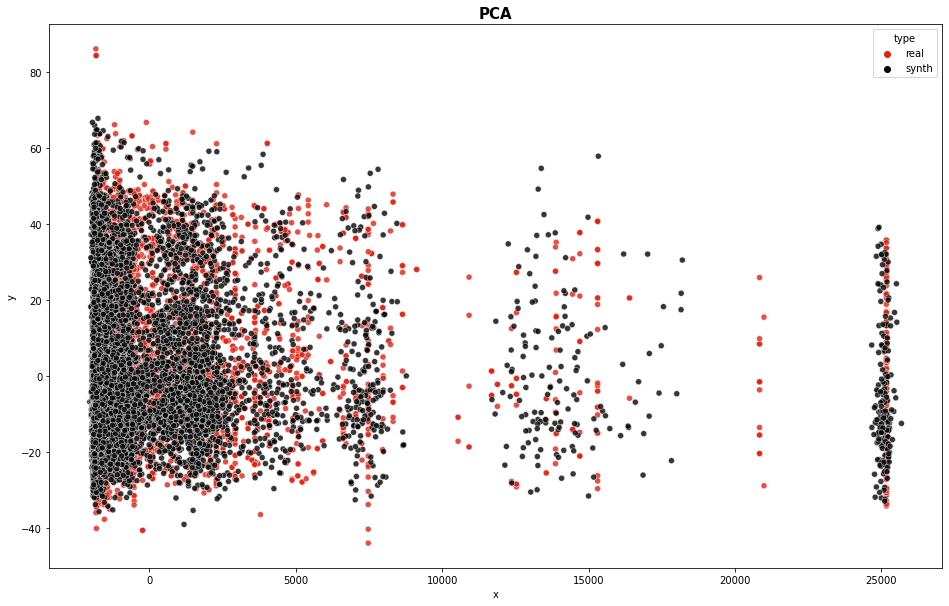

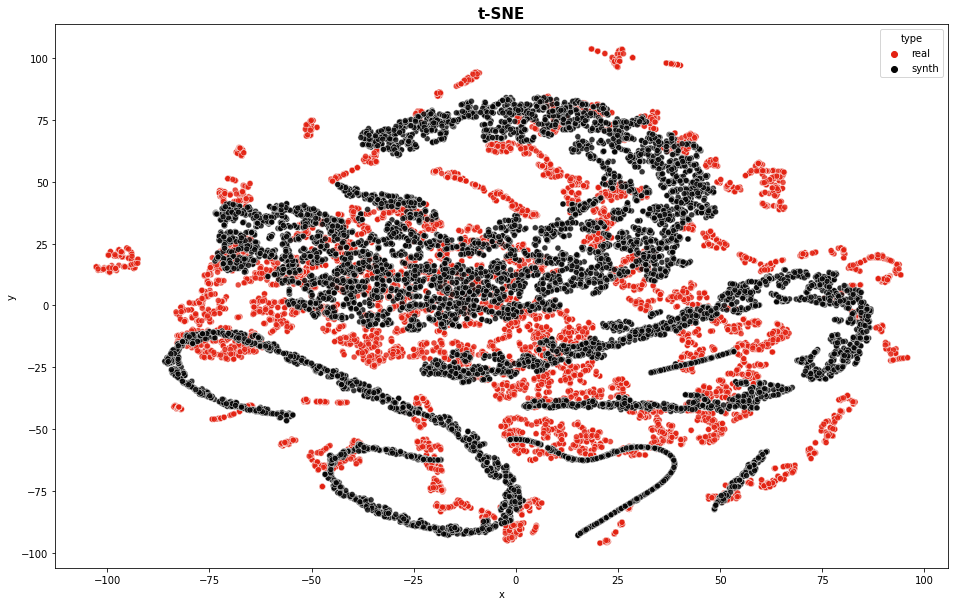

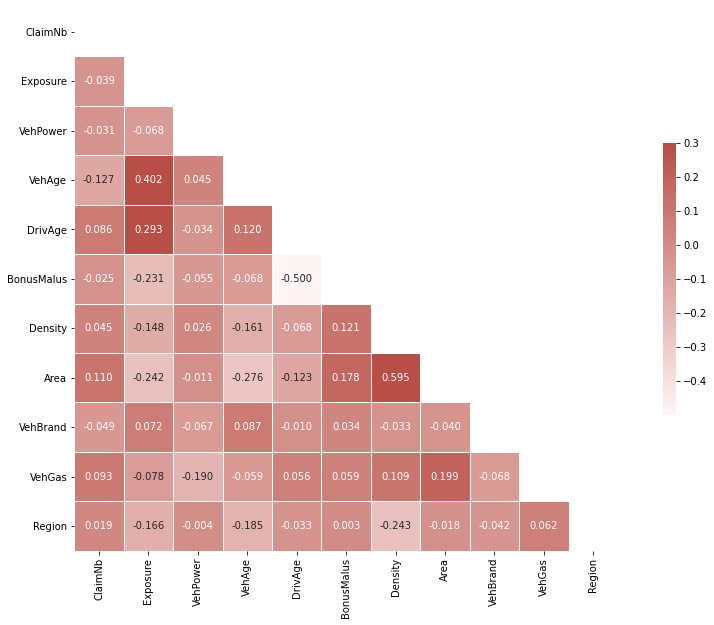

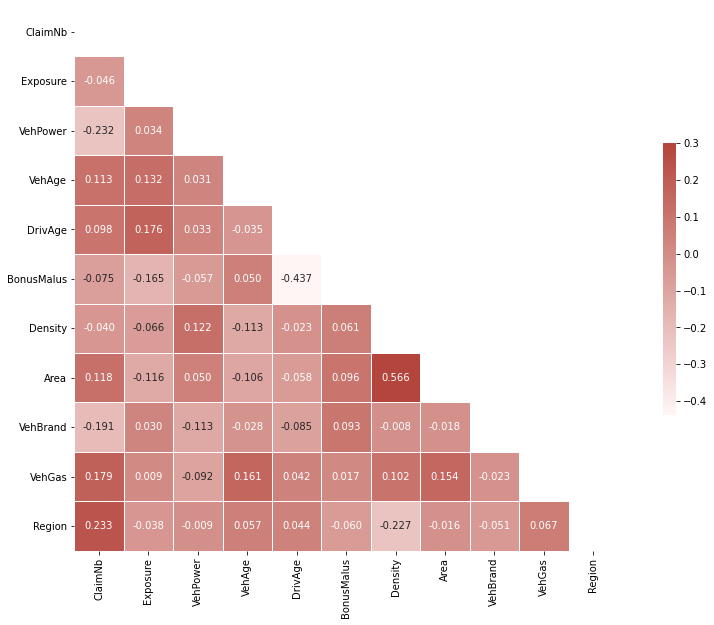

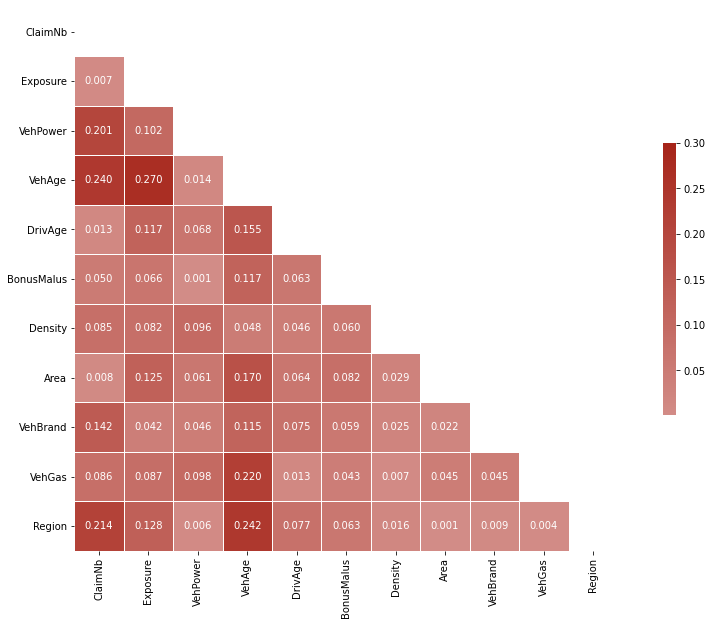

In [14]:
#Importing the method to generate the .pdf report
from ydata.report import SyntheticDataProfile
import warnings

profile = SyntheticDataProfile()
report_info = profile.generate_report(pd_data_processed[:10000], synth_data_processed[:10000],
                    target='Exposure', pdf=True, output_path ='./ydata_report.pdf')